Found 2303 unmatched points. Trying nearest approach...


C:\Users\ssara\Anaconda\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Points still without ocean labels: 8 (0.00%)
    lat   lon  mp_concentration                time  lon_converted  \
0 -37.0  0.00      12866.504883 2018-08-16 12:00:00           0.00   
1 -37.0  0.25      12746.297852 2018-08-16 12:00:00           0.25   
2 -37.0  0.50      12626.090820 2018-08-16 12:00:00           0.50   
3 -37.0  0.75      12505.883789 2018-08-16 12:00:00           0.75   
4 -37.0  1.00      12385.675781 2018-08-16 12:00:00           1.00   

           geometry  index_right                  name featurecla  has_label  
0     POINT (0 -37)          6.0  South Atlantic Ocean      ocean       True  
1  POINT (0.25 -37)          6.0  South Atlantic Ocean      ocean       True  
2   POINT (0.5 -37)          6.0  South Atlantic Ocean      ocean       True  
3  POINT (0.75 -37)          6.0  South Atlantic Ocean      ocean       True  
4     POINT (1 -37)          6.0  South Atlantic Ocean      ocean       True  

Microplastic concentration by ocean:
                      

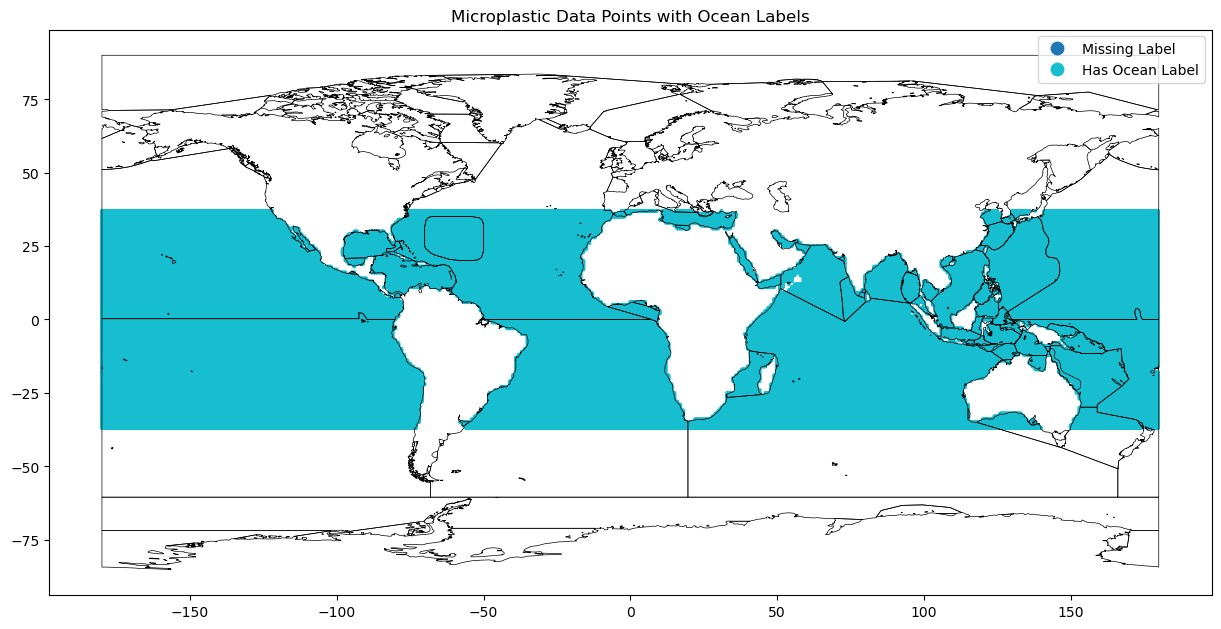

In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load the NetCDF file
nc_file = "cyg.ddmi.s20180816-120000-e20180816-120000.l3.grid-microplastic.a32.d33.nc"
ds = xr.open_dataset(nc_file)

# Convert NetCDF to DataFrame
df = ds.to_dataframe().reset_index()

# Extract necessary columns
df = df[["lat", "lon", "mp_concentration", "time"]].dropna()

# Convert longitude from 0-360 to -180 to 180 range
df['lon_converted'] = (df['lon'] + 180) % 360 - 180

# Create a GeoDataFrame with the corrected coordinates
geometry = [Point(lon, lat) for lon, lat in zip(df["lon_converted"], df["lat"])]
gdf_mp = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load the shapefile containing ocean names
shapefile = "ne_10m_geography_marine_polys.shp"
gdf_ocean = gpd.read_file(shapefile)
gdf_ocean = gdf_ocean[["geometry", "name", "featurecla"]].to_crs("EPSG:4326")

# Check if any invalid geometries exist and fix them
gdf_ocean['geometry'] = gdf_ocean['geometry'].buffer(0)

# Try different spatial join approaches
# 1. First try 'within'
gdf_final = gpd.sjoin(gdf_mp, gdf_ocean, how="left", predicate="within")

# 2. For points without matches, try 'nearest' approach with the remaining unmatched points
missing_labels = gdf_final[gdf_final["name"].isna()]
if not missing_labels.empty:
    print(f"Found {len(missing_labels)} unmatched points. Trying nearest approach...")
    
    # Create new GeoDataFrame with just the missing points
    gdf_missing = gdf_mp.loc[missing_labels.index]
    
    # Use 'nearest' predicate for remaining points
    # Note: This might be computationally intensive for large datasets
    nearest_join = gpd.sjoin_nearest(gdf_missing, gdf_ocean, how="left", max_distance=1.0)
    
    # Update the original dataframe with these new matches
    for idx, row in nearest_join.iterrows():
        if not pd.isna(row['name']):
            gdf_final.loc[idx, 'name'] = row['name']
            gdf_final.loc[idx, 'featurecla'] = row['featurecla']
            gdf_final.loc[idx, 'index_right'] = row['index_right']

# Check remaining unmatched data
still_missing = gdf_final[gdf_final["name"].isna()]
print(f"Points still without ocean labels: {len(still_missing)} ({len(still_missing)/len(gdf_final)*100:.2f}%)")

# Create columns for visualization
gdf_final['has_label'] = ~gdf_final['name'].isna()

# Basic visualization to check spatial join results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_ocean.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf_final.plot(column='has_label', ax=ax, markersize=3, 
               legend=True, categorical=True, 
               legend_kwds={'labels': ['Missing Label', 'Has Ocean Label']})
plt.title('Microplastic Data Points with Ocean Labels')
plt.savefig('microplastic_ocean_labels.png', dpi=300)

# Save the final dataset
gdf_final.to_csv("microplastic_ocean_claude.csv", index=False)
print(gdf_final.head())

# Optional: Generate statistics by ocean
if not gdf_final[gdf_final['name'].notna()].empty:
    ocean_stats = gdf_final.groupby('name')['mp_concentration'].agg(['mean', 'min', 'max', 'count']).sort_values('count', ascending=False)
    print("\nMicroplastic concentration by ocean:")
    print(ocean_stats)

In [2]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, box

# Load the NetCDF file
nc_file = "cyg.ddmi.s20180816-120000-e20180816-120000.l3.grid-microplastic.a32.d33.nc"
ds = xr.open_dataset(nc_file)

# Convert NetCDF to DataFrame - only extract needed columns directly
df = ds[["lat", "lon", "mp_concentration"]].to_dataframe().reset_index()
df = df.dropna(subset=["mp_concentration"])

# Convert longitude from 0-360 to -180 to 180 range
df['lon'] = (df['lon'] + 180) % 360 - 180

# Define key ocean garbage patch areas of interest (approximate bounding boxes)
# Format: [name, min_lon, min_lat, max_lon, max_lat]
garbage_patches = [
    ["North Pacific Gyre", -180, 25, -125, 45],    # Eastern Garbage Patch
    ["North Pacific Gyre", 125, 25, 180, 45],      # Western Garbage Patch
    ["North Atlantic Gyre", -70, 25, -40, 42],     # North Atlantic
    ["South Pacific Gyre", -150, -40, -85, -15],   # South Pacific
    ["South Atlantic Gyre", -40, -40, 15, -15],    # South Atlantic
    ["Indian Ocean Gyre", 60, -40, 110, -15]       # Indian Ocean
]

# Filter data to only include points in areas of interest
in_area_indices = []
area_labels = []

for area in garbage_patches:
    name, min_lon, min_lat, max_lon, max_lat = area
    
    # Find points that fall within this bounding box
    mask = ((df['lon'] >= min_lon) & (df['lon'] <= max_lon) & 
            (df['lat'] >= min_lat) & (df['lat'] <= max_lat))
    
    matching_indices = df.index[mask].tolist()
    in_area_indices.extend(matching_indices)
    area_labels.extend([name] * len(matching_indices))

# Create a filtered dataframe with only points in areas of interest
df_filtered = df.loc[in_area_indices].copy()
df_filtered['ocean_area'] = area_labels

# If you still need to join with actual marine polygons for more precise naming
# but only do this for the much smaller filtered dataset
if False:  # Set to True only if needed
    geometry = [Point(lon, lat) for lon, lat in zip(df_filtered["lon"], df_filtered["lat"])]
    gdf_filtered = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")
    
    # Load only needed parts of shapefile
    shapefile = "ne_10m_geography_marine_polys.shp"
    gdf_ocean = gpd.read_file(shapefile)[["geometry", "name", "featurecla"]]
    
    # Join only filtered data with shapefile
    gdf_final = gpd.sjoin(gdf_filtered, gdf_ocean, how="left", predicate="within")
else:
    # Skip shapefile join and just use our bounding box classifications
    gdf_final = df_filtered

# Save the filtered data for visualization
gdf_final.to_csv("mp_garbage_patches.csv", index=False)

# Basic summary statistics by area
patch_stats = gdf_final.groupby('ocean_area')['mp_concentration'].agg(['mean', 'min', 'max', 'count'])
print("Dataset filtered to focus on known garbage patches:")
print(f"Total points: {len(gdf_final)} (reduced from {len(df)})")
print("\nSummary by area:")
print(patch_stats)

Dataset filtered to focus on known garbage patches:
Total points: 87238 (reduced from 311077)

Summary by area:
                             mean           min           max  count
ocean_area                                                          
Indian Ocean Gyre    12878.003906  11742.282227  14470.284180  17889
North Atlantic Gyre  14353.894531  12471.363281  16337.985352   5929
North Pacific Gyre   12981.230469  12064.253906  14502.584961  20922
South Atlantic Gyre  12899.430664  10428.514648  14288.999023  19269
South Pacific Gyre   12658.339844  11898.325195  13813.022461  23229
